# [순환신경망 실습: 단변량 시계열 예측 모델링]

### 1. 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

### 2. 데이터 불러오기: YAHOO에서 한화 주식 데이터 불러오기

In [2]:
hanhwa_stock = pd.read_csv("Data/regression_univariate_hanhwa_stock.csv", engine='python')

In [3]:
hanhwa_stock.head()

,Date,Stock
0,2010-01-04,39034.73828
1,2010-01-05,39153.75000
2,2010-01-06,40145.45703
3,2010-01-07,39986.80859
4,2010-01-08,40145.45703


In [4]:
hanhwa_stock.tail()

,Date,Stock
2214,2018-12-21,32400.0
2215,2018-12-24,31950.0
2216,2018-12-26,31200.0
2217,2018-12-27,31850.0
2218,2018-12-28,31350.0


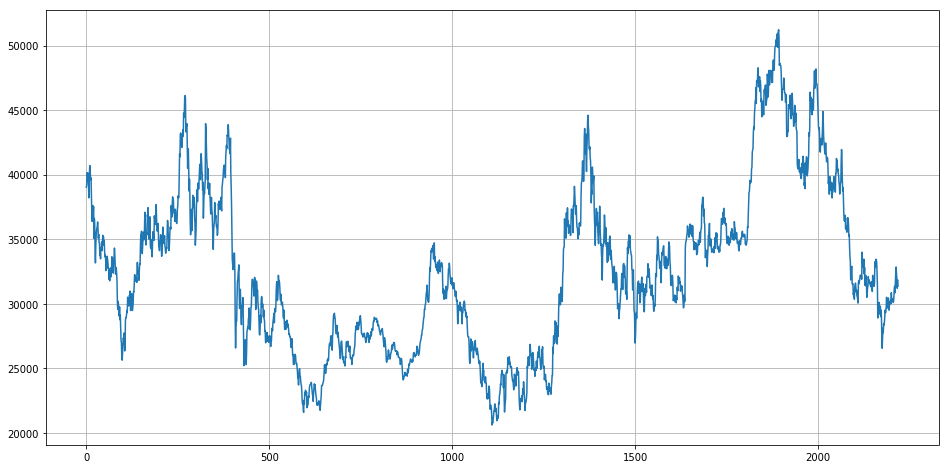

In [5]:
plt.figure(figsize=(16,8))
hanhwa_stock.Stock.plot(grid=True)
plt.show()

In [6]:
print(hanhwa_stock.isna().sum())

Date     0
Stock    0
dtype: int64


In [7]:
hanhwa_stock.shape

(2219, 2)

### 3. 데이터 전처리: sequence 길이에 맞게  RNN Input 데이터 만들기

In [8]:
hanhwa_stock = hanhwa_stock.set_index('Date')

In [9]:
hanhwa_stock.head()

,Stock
Date,
2010-01-04,39034.73828
2010-01-05,39153.75000
2010-01-06,40145.45703
2010-01-07,39986.80859
2010-01-08,40145.45703


In [10]:
data = hanhwa_stock[::-1]  # reverse order

In [11]:
data.head()

,Stock
Date,
2018-12-28,31350.0
2018-12-27,31850.0
2018-12-26,31200.0
2018-12-24,31950.0
2018-12-21,32400.0


In [12]:
len(data)

2219

In [13]:
# split train-test set
train_size = int(len(data) * 0.7)

In [14]:
train_set = data[0:train_size]
test_set = data[train_size:]

In [15]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [16]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [17]:
train_set.head()

,Stock
Date,
2018-12-28,0.350883
2018-12-27,0.367201
2018-12-26,0.345987
2018-12-24,0.370465
2018-12-21,0.385152


### 3. 데이터 전처리: sequence 길이에 맞게  RNN Input 데이터 만들기

In [18]:
def build_dataset(time_series, seq_length):
    dataT_1 = []
    dataT = []
    for i in range(0, len(time_series) - seq_length):
        _t_1 = time_series.iloc[i:i + seq_length, :]
        _t = time_series.iloc[i + seq_length, [-1]]  # Next close price
        print(_t_1, "->", _t)
        dataT_1.append(_t_1)
        dataT.append(_t)
    return np.stack(dataT_1), np.stack(dataT)

#### 사용자가 설정하는 Hyperparameters
- seq_length: 시퀀스 길이
- input_dim: 변수 개수
- hidden_dim: hidden state 차원(=하나의 hidden state 내 특징을 어느 크기로 추출할 것인지)
- layers: hidden state 개수(= 추출하는 특징을 몇개의 hidden state로 구성할 것인지)
- output_dim: 출력 크기(회귀에서는 1, 분류에서는 클래스 개수)
- learning_rate: 학습률
- n_epochs: 학습 반복 회수

In [19]:
# make train-test dataset to input
seq_length = 1
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)


               Stock
Date                
2018-12-28  0.350883 -> Stock    0.367201
Name: 2018-12-27, dtype: float64
               Stock
Date                
2018-12-27  0.367201 -> Stock    0.345987
Name: 2018-12-26, dtype: float64
               Stock
Date                
2018-12-26  0.345987 -> Stock    0.370465
Name: 2018-12-24, dtype: float64
               Stock
Date                
2018-12-24  0.370465 -> Stock    0.385152
Name: 2018-12-21, dtype: float64
               Stock
Date                
2018-12-21  0.385152 -> Stock    0.399838
Name: 2018-12-20, dtype: float64
               Stock
Date                
2018-12-20  0.399838 -> Stock    0.38352
Name: 2018-12-19, dtype: float64
              Stock
Date               
2018-12-19  0.38352 -> Stock    0.359042
Name: 2018-12-18, dtype: float64
               Stock
Date                
2018-12-18  0.359042 -> Stock    0.334564
Name: 2018-12-17, dtype: float64
               Stock
Date                
2018-12-17  0.334564 -> St

2018-09-13  0.337828 -> Stock    0.352515
Name: 2018-09-12, dtype: float64
               Stock
Date                
2018-09-12  0.352515 -> Stock    0.345987
Name: 2018-09-11, dtype: float64
               Stock
Date                
2018-09-11  0.345987 -> Stock    0.362306
Name: 2018-09-10, dtype: float64
               Stock
Date                
2018-09-10  0.362306 -> Stock    0.350883
Name: 2018-09-07, dtype: float64
               Stock
Date                
2018-09-07  0.350883 -> Stock    0.352515
Name: 2018-09-06, dtype: float64
               Stock
Date                
2018-09-06  0.352515 -> Stock    0.355778
Name: 2018-09-05, dtype: float64
               Stock
Date                
2018-09-05  0.355778 -> Stock    0.359042
Name: 2018-09-04, dtype: float64
               Stock
Date                
2018-09-04  0.359042 -> Stock    0.359042
Name: 2018-09-03, dtype: float64
               Stock
Date                
2018-09-03  0.359042 -> Stock    0.367201
Name: 2018-08-31, dtyp

Name: 2018-06-01, dtype: float64
               Stock
Date                
2018-06-01  0.501013 -> Stock    0.502645
Name: 2018-05-31, dtype: float64
               Stock
Date                
2018-05-31  0.502645 -> Stock    0.496117
Name: 2018-05-30, dtype: float64
               Stock
Date                
2018-05-30  0.496117 -> Stock    0.530386
Name: 2018-05-29, dtype: float64
               Stock
Date                
2018-05-29  0.530386 -> Stock    0.527122
Name: 2018-05-28, dtype: float64
               Stock
Date                
2018-05-28  0.527122 -> Stock    0.515699
Name: 2018-05-25, dtype: float64
               Stock
Date                
2018-05-25  0.515699 -> Stock    0.520595
Name: 2018-05-24, dtype: float64
               Stock
Date                
2018-05-24  0.520595 -> Stock    0.538545
Name: 2018-05-23, dtype: float64
               Stock
Date                
2018-05-23  0.538545 -> Stock    0.57771
Name: 2018-05-21, dtype: float64
              Stock
Date        

Name: 2018-02-19, dtype: float64
               Stock
Date                
2018-02-19  0.724576 -> Stock    0.690307
Name: 2018-02-14, dtype: float64
               Stock
Date                
2018-02-14  0.690307 -> Stock    0.693571
Name: 2018-02-13, dtype: float64
               Stock
Date                
2018-02-13  0.693571 -> Stock    0.72784
Name: 2018-02-12, dtype: float64
              Stock
Date               
2018-02-12  0.72784 -> Stock    0.752317
Name: 2018-02-09, dtype: float64
               Stock
Date                
2018-02-09  0.752317 -> Stock    0.747422
Name: 2018-02-08, dtype: float64
               Stock
Date                
2018-02-08  0.747422 -> Stock    0.753949
Name: 2018-02-07, dtype: float64
               Stock
Date                
2018-02-07  0.753949 -> Stock    0.776795
Name: 2018-02-06, dtype: float64
               Stock
Date                
2018-02-06  0.776795 -> Stock    0.812696
Name: 2018-02-05, dtype: float64
               Stock
Date          

Name: 2017-11-03, dtype: float64
               Stock
Date                
2017-11-03  0.803828 -> Stock    0.808652
Name: 2017-11-02, dtype: float64
               Stock
Date                
2017-11-02  0.808652 -> Stock    0.766845
Name: 2017-11-01, dtype: float64
               Stock
Date                
2017-11-01  0.766845 -> Stock    0.763629
Name: 2017-10-31, dtype: float64
               Stock
Date                
2017-10-31  0.763629 -> Stock    0.755589
Name: 2017-10-30, dtype: float64
               Stock
Date                
2017-10-30  0.755589 -> Stock    0.787748
Name: 2017-10-27, dtype: float64
               Stock
Date                
2017-10-27  0.787748 -> Stock    0.784532
Name: 2017-10-26, dtype: float64
               Stock
Date                
2017-10-26  0.784532 -> Stock    0.819908
Name: 2017-10-25, dtype: float64
               Stock
Date                
2017-10-25  0.819908 -> Stock    0.839203
Name: 2017-10-24, dtype: float64
               Stock
Date      

2017-07-18  0.860107 -> Stock    0.892266
Name: 2017-07-17, dtype: float64
               Stock
Date                
2017-07-17  0.892266 -> Stock    0.89709
Name: 2017-07-14, dtype: float64
              Stock
Date               
2017-07-14  0.89709 -> Stock    0.839203
Name: 2017-07-13, dtype: float64
               Stock
Date                
2017-07-13  0.839203 -> Stock    0.829556
Name: 2017-07-12, dtype: float64
               Stock
Date                
2017-07-12  0.829556 -> Stock    0.88101
Name: 2017-07-11, dtype: float64
              Stock
Date               
2017-07-11  0.88101 -> Stock    0.887442
Name: 2017-07-10, dtype: float64
               Stock
Date                
2017-07-10  0.887442 -> Stock    0.824732
Name: 2017-07-07, dtype: float64
               Stock
Date                
2017-07-07  0.824732 -> Stock    0.821516
Name: 2017-07-06, dtype: float64
               Stock
Date                
2017-07-06  0.821516 -> Stock    0.81026
Name: 2017-07-05, dtype: float6

Name: 2017-04-03, dtype: float64
               Stock
Date                
2017-04-03  0.477411 -> Stock    0.482235
Name: 2017-03-31, dtype: float64
               Stock
Date                
2017-03-31  0.482235 -> Stock    0.477411
Name: 2017-03-30, dtype: float64
               Stock
Date                
2017-03-30  0.477411 -> Stock    0.490274
Name: 2017-03-29, dtype: float64
               Stock
Date                
2017-03-29  0.490274 -> Stock    0.485451
Name: 2017-03-28, dtype: float64
               Stock
Date                
2017-03-28  0.485451 -> Stock    0.472587
Name: 2017-03-27, dtype: float64
               Stock
Date                
2017-03-27  0.472587 -> Stock    0.474195
Name: 2017-03-24, dtype: float64
               Stock
Date                
2017-03-24  0.474195 -> Stock    0.470979
Name: 2017-03-23, dtype: float64
               Stock
Date                
2017-03-23  0.470979 -> Stock    0.456507
Name: 2017-03-22, dtype: float64
               Stock
Date      

Name: 2016-12-20, dtype: float64
               Stock
Date                
2016-12-20  0.445142 -> Stock    0.446722
Name: 2016-12-19, dtype: float64
               Stock
Date                
2016-12-19  0.446722 -> Stock    0.467269
Name: 2016-12-16, dtype: float64
               Stock
Date                
2016-12-16  0.467269 -> Stock    0.484655
Name: 2016-12-15, dtype: float64
               Stock
Date                
2016-12-15  0.484655 -> Stock    0.475171
Name: 2016-12-14, dtype: float64
               Stock
Date                
2016-12-14  0.475171 -> Stock    0.486235
Name: 2016-12-13, dtype: float64
               Stock
Date                
2016-12-13  0.486235 -> Stock    0.464108
Name: 2016-12-12, dtype: float64
               Stock
Date                
2016-12-12  0.464108 -> Stock    0.446722
Name: 2016-12-09, dtype: float64
               Stock
Date                
2016-12-09  0.446722 -> Stock    0.473591
Name: 2016-12-08, dtype: float64
               Stock
Date      

Name: 2016-09-07, dtype: float64
               Stock
Date                
2016-09-07  0.476752 -> Stock    0.486235
Name: 2016-09-06, dtype: float64
               Stock
Date                
2016-09-06  0.486235 -> Stock    0.505201
Name: 2016-09-05, dtype: float64
               Stock
Date                
2016-09-05  0.505201 -> Stock    0.490977
Name: 2016-09-02, dtype: float64
               Stock
Date                
2016-09-02  0.490977 -> Stock    0.483074
Name: 2016-09-01, dtype: float64
               Stock
Date                
2016-09-01  0.483074 -> Stock    0.486235
Name: 2016-08-31, dtype: float64
               Stock
Date                
2016-08-31  0.486235 -> Stock    0.508362
Name: 2016-08-30, dtype: float64
               Stock
Date                
2016-08-30  0.508362 -> Stock    0.50046
Name: 2016-08-29, dtype: float64
              Stock
Date               
2016-08-29  0.50046 -> Stock    0.492557
Name: 2016-08-26, dtype: float64
               Stock
Date          

2016-05-30  0.395311 -> Stock    0.417934
Name: 2016-05-27, dtype: float64
               Stock
Date                
2016-05-27  0.417934 -> Stock    0.425006
Name: 2016-05-26, dtype: float64
               Stock
Date                
2016-05-26  0.425006 -> Stock    0.426419
Name: 2016-05-25, dtype: float64
               Stock
Date                
2016-05-25  0.426419 -> Stock    0.396724
Name: 2016-05-24, dtype: float64
               Stock
Date                
2016-05-24  0.396724 -> Stock    0.417934
Name: 2016-05-23, dtype: float64
               Stock
Date                
2016-05-23  0.417934 -> Stock    0.402382
Name: 2016-05-20, dtype: float64
               Stock
Date                
2016-05-20  0.402382 -> Stock    0.413692
Name: 2016-05-19, dtype: float64
               Stock
Date                
2016-05-19  0.413692 -> Stock    0.453288
Name: 2016-05-18, dtype: float64
               Stock
Date                
2016-05-18  0.453288 -> Stock    0.451871
Name: 2016-05-17, dtyp

Name: 2016-02-15, dtype: float64
               Stock
Date                
2016-02-15  0.348648 -> Stock    0.314711
Name: 2016-02-12, dtype: float64
               Stock
Date                
2016-02-12  0.314711 -> Stock    0.309056
Name: 2016-02-11, dtype: float64
               Stock
Date                
2016-02-11  0.309056 -> Stock    0.357132
Name: 2016-02-05, dtype: float64
               Stock
Date                
2016-02-05  0.357132 -> Stock    0.348648
Name: 2016-02-04, dtype: float64
               Stock
Date                
2016-02-04  0.348648 -> Stock    0.333092
Name: 2016-02-03, dtype: float64
               Stock
Date                
2016-02-03  0.333092 -> Stock    0.364203
Name: 2016-02-02, dtype: float64
               Stock
Date                
2016-02-02  0.364203 -> Stock    0.357132
Name: 2016-02-01, dtype: float64
               Stock
Date                
2016-02-01  0.357132 -> Stock    0.358545
Name: 2016-01-29, dtype: float64
               Stock
Date      

2015-10-30  0.375002 -> Stock    0.359661
Name: 2015-10-29, dtype: float64
               Stock
Date                
2015-10-29  0.359661 -> Stock    0.401497
Name: 2015-10-28, dtype: float64
               Stock
Date                
2015-10-28  0.401497 -> Stock    0.391736
Name: 2015-10-27, dtype: float64
               Stock
Date                
2015-10-27  0.391736 -> Stock    0.365238
Name: 2015-10-26, dtype: float64
               Stock
Date                
2015-10-26  0.365238 -> Stock    0.381972
Name: 2015-10-23, dtype: float64
               Stock
Date                
2015-10-23  0.381972 -> Stock    0.359661
Name: 2015-10-22, dtype: float64
               Stock
Date                
2015-10-22  0.359661 -> Stock    0.39313
Name: 2015-10-21, dtype: float64
              Stock
Date               
2015-10-21  0.39313 -> Stock    0.400103
Name: 2015-10-20, dtype: float64
               Stock
Date                
2015-10-20  0.400103 -> Stock    0.409864
Name: 2015-10-19, dtype: f

Name: 2015-07-20, dtype: float64
               Stock
Date                
2015-07-20  0.702714 -> Stock    0.74455
Name: 2015-07-17, dtype: float64
              Stock
Date               
2015-07-17  0.74455 -> Stock    0.755704
Name: 2015-07-16, dtype: float64
               Stock
Date                
2015-07-16  0.755704 -> Stock    0.783596
Name: 2015-07-15, dtype: float64
               Stock
Date                
2015-07-15  0.783596 -> Stock    0.769652
Name: 2015-07-14, dtype: float64
               Stock
Date                
2015-07-14  0.769652 -> Stock    0.722236
Name: 2015-07-13, dtype: float64
               Stock
Date                
2015-07-13  0.722236 -> Stock    0.697134
Name: 2015-07-10, dtype: float64
               Stock
Date                
2015-07-10  0.697134 -> Stock    0.641354
Name: 2015-07-09, dtype: float64
               Stock
Date                
2015-07-09  0.641354 -> Stock    0.674823
Name: 2015-07-08, dtype: float64
               Stock
Date          

Name: 2015-04-08, dtype: float64
               Stock
Date                
2015-04-08  0.444726 -> Stock    0.388946
Name: 2015-04-07, dtype: float64
               Stock
Date                
2015-04-07  0.388946 -> Stock    0.383369
Name: 2015-04-06, dtype: float64
               Stock
Date                
2015-04-06  0.383369 -> Stock    0.326192
Name: 2015-04-03, dtype: float64
               Stock
Date                
2015-04-03  0.326192 -> Stock    0.312248
Name: 2015-04-02, dtype: float64
               Stock
Date                
2015-04-02  0.312248 -> Stock    0.341533
Name: 2015-04-01, dtype: float64
               Stock
Date                
2015-04-01  0.341533 -> Stock    0.341533
Name: 2015-03-31, dtype: float64
               Stock
Date                
2015-03-31  0.341533 -> Stock    0.348504
Name: 2015-03-30, dtype: float64
               Stock
Date                
2015-03-30  0.348504 -> Stock    0.305275
Name: 2015-03-27, dtype: float64
               Stock
Date      

Name: 2014-12-23, dtype: float64
               Stock
Date                
2014-12-23  0.184845 -> Stock    0.168414
Name: 2014-12-22, dtype: float64
               Stock
Date                
2014-12-22  0.168414 -> Stock    0.143768
Name: 2014-12-19, dtype: float64
               Stock
Date                
2014-12-19  0.143768 -> Stock    0.147876
Name: 2014-12-18, dtype: float64
               Stock
Date                
2014-12-18  0.147876 -> Stock    0.161567
Name: 2014-12-17, dtype: float64
               Stock
Date                
2014-12-17  0.161567 -> Stock    0.138292
Name: 2014-12-16, dtype: float64
               Stock
Date                
2014-12-16  0.138292 -> Stock    0.145136
Name: 2014-12-15, dtype: float64
               Stock
Date                
2014-12-15  0.145136 -> Stock    0.132813
Name: 2014-12-12, dtype: float64
               Stock
Date                
2014-12-12  0.132813 -> Stock    0.12323
Name: 2014-12-11, dtype: float64
              Stock
Date        

2014-09-12  0.119122 -> Stock    0.124598
Name: 2014-09-11, dtype: float64
               Stock
Date                
2014-09-11  0.124598 -> Stock    0.146508
Name: 2014-09-05, dtype: float64
               Stock
Date                
2014-09-05  0.146508 -> Stock    0.145136
Name: 2014-09-04, dtype: float64
               Stock
Date                
2014-09-04  0.145136 -> Stock    0.149244
Name: 2014-09-03, dtype: float64
               Stock
Date                
2014-09-03  0.149244 -> Stock    0.146508
Name: 2014-09-02, dtype: float64
               Stock
Date                
2014-09-02  0.146508 -> Stock    0.158831
Name: 2014-09-01, dtype: float64
               Stock
Date                
2014-09-01  0.158831 -> Stock    0.156091
Name: 2014-08-29, dtype: float64
               Stock
Date                
2014-08-29  0.156091 -> Stock    0.172522
Name: 2014-08-28, dtype: float64
               Stock
Date                
2014-08-28  0.172522 -> Stock    0.167046
Name: 2014-08-27, dtyp

Name: 2014-05-28, dtype: float64
               Stock
Date                
2014-05-28  0.105431 -> Stock    0.109539
Name: 2014-05-27, dtype: float64
               Stock
Date                
2014-05-27  0.109539 -> Stock    0.121862
Name: 2014-05-26, dtype: float64
               Stock
Date                
2014-05-26  0.121862 -> Stock    0.106799
Name: 2014-05-23, dtype: float64
               Stock
Date                
2014-05-23  0.106799 -> Stock    0.108168
Name: 2014-05-22, dtype: float64
               Stock
Date                
2014-05-22  0.108168 -> Stock    0.113646
Name: 2014-05-21, dtype: float64
               Stock
Date                
2014-05-21  0.113646 -> Stock    0.113646
Name: 2014-05-20, dtype: float64
               Stock
Date                
2014-05-20  0.113646 -> Stock    0.138292
Name: 2014-05-19, dtype: float64
               Stock
Date                
2014-05-19  0.138292 -> Stock    0.135553
Name: 2014-05-16, dtype: float64
               Stock
Date      

Name: 2014-02-14, dtype: float64
               Stock
Date                
2014-02-14  0.288905 -> Stock    0.29986
Name: 2014-02-13, dtype: float64
              Stock
Date               
2014-02-13  0.29986 -> Stock    0.310814
Name: 2014-02-12, dtype: float64
               Stock
Date                
2014-02-12  0.310814 -> Stock    0.291644
Name: 2014-02-11, dtype: float64
               Stock
Date                
2014-02-11  0.291644 -> Stock    0.293012
Name: 2014-02-10, dtype: float64
               Stock
Date                
2014-02-10  0.293012 -> Stock    0.302599
Name: 2014-02-07, dtype: float64
               Stock
Date                
2014-02-07  0.302599 -> Stock    0.287537
Name: 2014-02-06, dtype: float64
               Stock
Date                
2014-02-06  0.287537 -> Stock    0.266998
Name: 2014-02-05, dtype: float64
               Stock
Date                
2014-02-05  0.266998 -> Stock    0.256043
Name: 2014-02-04, dtype: float64
               Stock
Date          

2013-11-01  0.425487 -> Stock    0.414657
Name: 2013-10-31, dtype: float64
               Stock
Date                
2013-10-31  0.414657 -> Stock    0.460679
Name: 2013-10-30, dtype: float64
               Stock
Date                
2013-10-30  0.460679 -> Stock    0.432253
Name: 2013-10-29, dtype: float64
               Stock
Date                
2013-10-29  0.432253 -> Stock    0.420071
Name: 2013-10-28, dtype: float64
               Stock
Date                
2013-10-28  0.420071 -> Stock    0.440375
Name: 2013-10-25, dtype: float64
               Stock
Date                
2013-10-25  0.440375 -> Stock    0.453913
Name: 2013-10-24, dtype: float64
               Stock
Date                
2013-10-24  0.453913 -> Stock    0.443083
Name: 2013-10-23, dtype: float64
               Stock
Date                
2013-10-23  0.443083 -> Stock    0.447144
Name: 2013-10-22, dtype: float64
               Stock
Date                
2013-10-22  0.447144 -> Stock    0.437669
Name: 2013-10-21, dtyp

Name: 2013-07-17, dtype: float64
               Stock
Date                
2013-07-17  0.154765 -> Stock    0.143935
Name: 2013-07-16, dtype: float64
               Stock
Date                
2013-07-16  0.143935 -> Stock    0.134461
Name: 2013-07-15, dtype: float64
               Stock
Date                
2013-07-15  0.134461 -> Stock    0.131753
Name: 2013-07-12, dtype: float64
               Stock
Date                
2013-07-12  0.131753 -> Stock    0.14123
Name: 2013-07-11, dtype: float64
              Stock
Date               
2013-07-11  0.14123 -> Stock    0.123631
Name: 2013-07-10, dtype: float64
               Stock
Date                
2013-07-10  0.123631 -> Stock    0.1304
Name: 2013-07-09, dtype: float64
             Stock
Date              
2013-07-09  0.1304 -> Stock    0.126339
Name: 2013-07-08, dtype: float64
               Stock
Date                
2013-07-08  0.126339 -> Stock    0.129047
Name: 2013-07-05, dtype: float64
               Stock
Date                
2

2013-04-05  0.211616 -> Stock    0.226507
Name: 2013-04-04, dtype: float64
               Stock
Date                
2013-04-04  0.226507 -> Stock    0.233273
Name: 2013-04-03, dtype: float64
               Stock
Date                
2013-04-03  0.233273 -> Stock    0.244103
Name: 2013-04-02, dtype: float64
               Stock
Date                
2013-04-02  0.244103 -> Stock    0.238689
Name: 2013-04-01, dtype: float64
               Stock
Date                
2013-04-01  0.238689 -> Stock    0.241395
Name: 2013-03-29, dtype: float64
               Stock
Date                
2013-03-29  0.241395 -> Stock    0.238689
Name: 2013-03-28, dtype: float64
               Stock
Date                
2013-03-28  0.238689 -> Stock    0.237334
Name: 2013-03-27, dtype: float64
               Stock
Date                
2013-03-27  0.237334 -> Stock    0.227859
Name: 2013-03-26, dtype: float64
               Stock
Date                
2013-03-26  0.227859 -> Stock    0.233273
Name: 2013-03-25, dtyp

Name: 2012-12-20, dtype: float64
               Stock
Date                
2012-12-20  0.257361 -> Stock    0.260027
Name: 2012-12-18, dtype: float64
               Stock
Date                
2012-12-18  0.260027 -> Stock    0.241356
Name: 2012-12-17, dtype: float64
               Stock
Date                
2012-12-17  0.241356 -> Stock    0.242688
Name: 2012-12-14, dtype: float64
               Stock
Date                
2012-12-14  0.242688 -> Stock    0.250691
Name: 2012-12-13, dtype: float64
               Stock
Date                
2012-12-13  0.250691 -> Stock    0.24002
Name: 2012-12-12, dtype: float64
              Stock
Date               
2012-12-12  0.24002 -> Stock    0.230684
Name: 2012-12-11, dtype: float64
               Stock
Date                
2012-12-11  0.230684 -> Stock    0.204008
Name: 2012-12-10, dtype: float64
               Stock
Date                
2012-12-10  0.204008 -> Stock    0.194672
Name: 2012-12-07, dtype: float64
               Stock
Date          

Name: 2012-09-10, dtype: float64
               Stock
Date                
2012-09-10  0.204008 -> Stock    0.22535
Name: 2012-09-07, dtype: float64
              Stock
Date               
2012-09-07  0.22535 -> Stock    0.22535
Name: 2012-09-06, dtype: float64
              Stock
Date               
2012-09-06  0.22535 -> Stock    0.22535
Name: 2012-09-05, dtype: float64
              Stock
Date               
2012-09-05  0.22535 -> Stock    0.206676
Name: 2012-09-04, dtype: float64
               Stock
Date                
2012-09-04  0.206676 -> Stock    0.200006
Name: 2012-09-03, dtype: float64
               Stock
Date                
2012-08-31  0.218015 -> Stock    0.213023
Name: 2012-08-30, dtype: float64
               Stock
Date                
2012-08-30  0.213023 -> Stock    0.196381
Name: 2012-08-29, dtype: float64
               Stock
Date                
2012-08-29  0.196381 -> Stock    0.164758
Name: 2012-08-28, dtype: float64
               Stock
Date                
2

2012-05-30  0.066569 -> Stock    0.069895
Name: 2012-05-29, dtype: float64
               Stock
Date                
2012-05-29  0.069895 -> Stock    0.054917
Name: 2012-05-25, dtype: float64
               Stock
Date                
2012-05-25  0.054917 -> Stock    0.063239
Name: 2012-05-24, dtype: float64
               Stock
Date                
2012-05-24  0.063239 -> Stock    0.026627
Name: 2012-05-23, dtype: float64
               Stock
Date                
2012-05-23  0.026627 -> Stock    0.038275
Name: 2012-05-22, dtype: float64
               Stock
Date                
2012-05-22  0.038275 -> Stock    0.0
Name: 2012-05-21, dtype: float64
            Stock
Date             
2012-05-21    0.0 -> Stock    0.006656
Name: 2012-05-18, dtype: float64
               Stock
Date                
2012-05-18  0.006656 -> Stock    0.033283
Name: 2012-05-17, dtype: float64
               Stock
Date                
2012-05-17  0.033283 -> Stock    0.026627
Name: 2012-05-16, dtype: float64
   

Name: 2012-02-15, dtype: float64
               Stock
Date                
2012-02-15  0.392763 -> Stock    0.411071
Name: 2012-02-14, dtype: float64
               Stock
Date                
2012-02-14  0.411071 -> Stock    0.416063
Name: 2012-02-13, dtype: float64
               Stock
Date                
2012-02-13  0.416063 -> Stock    0.414397
Name: 2012-02-10, dtype: float64
               Stock
Date                
2012-02-10  0.414397 -> Stock    0.432705
Name: 2012-02-09, dtype: float64
               Stock
Date                
2012-02-09  0.432705 -> Stock    0.376121
Name: 2012-02-08, dtype: float64
               Stock
Date                
2012-02-08  0.376121 -> Stock    0.357813
Name: 2012-02-07, dtype: float64
               Stock
Date                
2012-02-07  0.357813 -> Stock    0.35282
Name: 2012-02-06, dtype: float64
              Stock
Date               
2012-02-06  0.35282 -> Stock    0.412734
Name: 2012-02-03, dtype: float64
               Stock
Date          

Name: 2011-11-04, dtype: float64
               Stock
Date                
2011-11-04  0.395068 -> Stock    0.367201
Name: 2011-11-03, dtype: float64
               Stock
Date                
2011-11-03  0.367201 -> Stock    0.39671
Name: 2011-11-02, dtype: float64
              Stock
Date               
2011-11-02  0.39671 -> Stock    0.399986
Name: 2011-11-01, dtype: float64
               Stock
Date                
2011-11-01  0.399986 -> Stock    0.419659
Name: 2011-10-31, dtype: float64
               Stock
Date                
2011-10-31  0.419659 -> Stock    0.419659
Name: 2011-10-28, dtype: float64
               Stock
Date                
2011-10-28  0.419659 -> Stock    0.419659
Name: 2011-10-27, dtype: float64
               Stock
Date                
2011-10-27  0.419659 -> Stock    0.375395
Name: 2011-10-26, dtype: float64
               Stock
Date                
2011-10-26  0.375395 -> Stock    0.334412
Name: 2011-10-25, dtype: float64
               Stock
Date          

2011-07-25  0.878684 -> Stock    0.908193
Name: 2011-07-22, dtype: float64
               Stock
Date                
2011-07-22  0.908193 -> Stock    0.875408
Name: 2011-07-21, dtype: float64
               Stock
Date                
2011-07-21  0.875408 -> Stock    0.872128
Name: 2011-07-20, dtype: float64
               Stock
Date                
2011-07-20  0.872128 -> Stock    0.875408
Name: 2011-07-19, dtype: float64
               Stock
Date                
2011-07-19  0.875408 -> Stock    0.832783
Name: 2011-07-18, dtype: float64
               Stock
Date                
2011-07-18  0.832783 -> Stock    0.84262
Name: 2011-07-15, dtype: float64
              Stock
Date               
2011-07-15  0.84262 -> Stock    0.826227
Name: 2011-07-14, dtype: float64
               Stock
Date                
2011-07-14  0.826227 -> Stock    0.806554
Name: 2011-07-13, dtype: float64
               Stock
Date                
2011-07-13  0.806554 -> Stock    0.740976
Name: 2011-07-12, dtype: f

Name: 2011-04-12, dtype: float64
               Stock
Date                
2011-04-12  0.701631 -> Stock    0.750813
Name: 2011-04-11, dtype: float64
               Stock
Date                
2011-04-11  0.750813 -> Stock    0.760649
Name: 2011-04-08, dtype: float64
               Stock
Date                
2011-04-08  0.760649 -> Stock    0.793438
Name: 2011-04-07, dtype: float64
               Stock
Date                
2011-04-07  0.793438 -> Stock    0.816391
Name: 2011-04-06, dtype: float64
               Stock
Date                
2011-04-06  0.816391 -> Stock    0.773765
Name: 2011-04-05, dtype: float64
               Stock
Date                
2011-04-05  0.773765 -> Stock    0.73442
Name: 2011-04-04, dtype: float64
              Stock
Date               
2011-04-04  0.73442 -> Stock    0.783602
Name: 2011-04-01, dtype: float64
               Stock
Date                
2011-04-01  0.783602 -> Stock    0.780321
Name: 2011-03-31, dtype: float64
               Stock
Date          

2010-12-28  0.607512 -> Stock    0.596201
Name: 2010-12-27, dtype: float64
               Stock
Date                
2010-12-27  0.596201 -> Stock    0.605898
Name: 2010-12-24, dtype: float64
               Stock
Date                
2010-12-24  0.605898 -> Stock    0.609126
Name: 2010-12-23, dtype: float64
               Stock
Date                
2010-12-23  0.609126 -> Stock    0.636591
Name: 2010-12-22, dtype: float64
               Stock
Date                
2010-12-22  0.636591 -> Stock    0.641437
Name: 2010-12-21, dtype: float64
               Stock
Date                
2010-12-21  0.641437 -> Stock    0.602665
Name: 2010-12-20, dtype: float64
               Stock
Date                
2010-12-20  0.602665 -> Stock    0.628512
Name: 2010-12-17, dtype: float64
               Stock
Date                
2010-12-17  0.628512 -> Stock    0.628512
Name: 2010-12-16, dtype: float64
               Stock
Date                
2010-12-16  0.628512 -> Stock    0.633359
Name: 2010-12-15, dtyp

2010-09-16  0.517044 -> Stock    0.546122
Name: 2010-09-15, dtype: float64
               Stock
Date                
2010-09-15  0.546122 -> Stock    0.518662
Name: 2010-09-14, dtype: float64
               Stock
Date                
2010-09-14  0.518662 -> Stock    0.528355
Name: 2010-09-13, dtype: float64
               Stock
Date                
2010-09-13  0.528355 -> Stock    0.617205
Name: 2010-09-10, dtype: float64
               Stock
Date                
2010-09-10  0.617205 -> Stock    0.58328
Name: 2010-09-09, dtype: float64
              Stock
Date               
2010-09-09  0.58328 -> Stock    0.546122
Name: 2010-09-08, dtype: float64
               Stock
Date                
2010-09-08  0.546122 -> Stock    0.584894
Name: 2010-09-07, dtype: float64
               Stock
Date                
2010-09-07  0.584894 -> Stock    0.596201
Name: 2010-09-06, dtype: float64
               Stock
Date                
2010-09-06  0.596201 -> Stock    0.646284
Name: 2010-09-03, dtype: f

2010-06-10  0.298954 -> Stock    0.290879
Name: 2010-06-09, dtype: float64
               Stock
Date                
2010-06-09  0.290879 -> Stock    0.208489
Name: 2010-06-08, dtype: float64
               Stock
Date                
2010-06-08  0.208489 -> Stock    0.19395
Name: 2010-06-07, dtype: float64
              Stock
Date               
2010-06-07  0.19395 -> Stock    0.232722
Name: 2010-06-04, dtype: float64
               Stock
Date                
2010-06-04  0.232722 -> Stock    0.250489
Name: 2010-06-03, dtype: float64
               Stock
Date                
2010-06-03  0.250489 -> Stock    0.231104
Name: 2010-06-01, dtype: float64
               Stock
Date                
2010-06-01  0.231104 -> Stock    0.234336
Name: 2010-05-31, dtype: float64
               Stock
Date                
2010-05-31  0.234336 -> Stock    0.210104
Name: 2010-05-28, dtype: float64
               Stock
Date                
2010-05-28  0.210104 -> Stock    0.184257
Name: 2010-05-27, dtype: f

Name: 2010-02-25, dtype: float64
               Stock
Date                
2010-02-25  0.496044 -> Stock    0.533201
Name: 2010-02-24, dtype: float64
               Stock
Date                
2010-02-24  0.533201 -> Stock    0.53643
Name: 2010-02-23, dtype: float64
              Stock
Date               
2010-02-23  0.53643 -> Stock    0.56228
Name: 2010-02-22, dtype: float64
              Stock
Date               
2010-02-22  0.56228 -> Stock    0.549355
Name: 2010-02-19, dtype: float64
               Stock
Date                
2010-02-19  0.549355 -> Stock    0.580048
Name: 2010-02-18, dtype: float64
               Stock
Date                
2010-02-18  0.580048 -> Stock    0.601048
Name: 2010-02-17, dtype: float64
               Stock
Date                
2010-02-17  0.601048 -> Stock    0.586512
Name: 2010-02-16, dtype: float64
               Stock
Date                
2010-02-16  0.586512 -> Stock    0.581665
Name: 2010-02-12, dtype: float64
               Stock
Date              

In [20]:
train_set.head()

,Stock
Date,
2018-12-28,0.350883
2018-12-27,0.367201
2018-12-26,0.345987
2018-12-24,0.370465
2018-12-21,0.385152


# make train-test dataset to input
trainX, trainY = train_set['Stock t-1'], train_set['Stock t']
testX, testY = test_set['Stock t-1'], test_set['Stock t']

In [21]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

### 4. RNN 학습 및 평가: 다음 시점의 Close price 예측

In [22]:
class RNNRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim):
        super(RNNRegressor, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

data_dim = 1
hidden_dim = 1
output_dim = 1
layers = 1
learning_rate = 0.01
iterations = 50


In [23]:
input_dim = 1
hidden_dim = 1
output_dim = 1
layer_dim = 1
learning_rate = 0.01
n_epochs = 100

In [24]:
# loss & optimizer setting
model = RNNRegressor(input_dim, hidden_dim, output_dim, layer_dim)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
trainX_tensor

tensor([[[0.3509]],

        [[0.3672]],

        [[0.3460]],

        ...,

        [[0.2254]],

        [[0.2254]],

        [[0.2067]]])

In [26]:
# start training
for i in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, np.round(loss.item(),7))

0 1.3818827
1 1.302929
2 1.2269803
3 1.1540909
4 1.0842947
5 1.0176044
6 0.9540106
7 0.8934803
8 0.8359572
9 0.7813623
10 0.7295962
11 0.6805417
12 0.6340687
13 0.590039
14 0.5483134
15 0.5087564
16 0.4712423
17 0.4356582
18 0.4019063
19 0.369904
20 0.3395831
21 0.3108878
22 0.2837722
23 0.2581983
24 0.2341328
25 0.2115462
26 0.1904098
27 0.1706952
28 0.1523727
29 0.1354104
30 0.119774
31 0.1054258
32 0.0923251
33 0.0804274
34 0.0696851
35 0.0600472
36 0.0514596
37 0.0438654
38 0.0372057
39 0.0314192
40 0.0264433
41 0.0222144
42 0.0186687
43 0.0157421
44 0.0133716
45 0.0114951
46 0.0100524
47 0.0089858
48 0.0082399
49 0.0077629
50 0.0075065
51 0.007426
52 0.0074812
53 0.0076359
54 0.0078582
55 0.0081207
56 0.0084002
57 0.0086774
58 0.0089371
59 0.0091677
60 0.0093607
61 0.0095107
62 0.0096149
63 0.0096727
64 0.0096852
65 0.0096552
66 0.0095865
67 0.0094836
68 0.0093517
69 0.0091963
70 0.0090226
71 0.008836
72 0.0086415
73 0.0084435
74 0.0082461
75 0.0080528
76 0.0078664
77 0.0076893
78

### 5. 시각화 

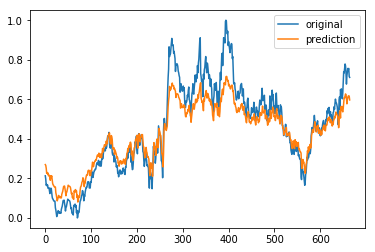

In [28]:
plt.plot(testY)
plt.plot(model(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

In [29]:
y_true = testY
y_pred = model(testX_tensor).data.numpy()

In [30]:
mean_absolute_error(model(testX_tensor).data.numpy(), testY)

0.066986594230173